In [14]:
# Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.datasets import EllipticBitcoinDataset
from sklearn.model_selection import train_test_split

In [11]:
DEVICE = torch.device('cpu')
print(f'Using device: {DEVICE}')

Using device: cpu


In [12]:
dataset = EllipticBitcoinDataset(root='./dataset')
data = dataset[0].to(DEVICE)
print(data)

Data(x=[203769, 165], edge_index=[2, 234355], y=[203769], train_mask=[203769], test_mask=[203769])


In [13]:
# Labels and masks
labels = data.y.clone().to(DEVICE)     # [num_nodes]
# known nodes: classes 0 and 1
known_mask = (labels == 0) | (labels == 1)
known_idx = known_mask.nonzero(as_tuple=True)[0]
# unknown nodes: class 2
unknown_idx = (labels == 2).nonzero(as_tuple=True)[0]

In [15]:
train_idx, val_idx = train_test_split(
    known_idx.cpu().numpy(),
    test_size=0.2,
    stratify=labels[known_idx].cpu().numpy(),
    random_state=42
)
train_idx = torch.tensor(train_idx, dtype=torch.long, device=DEVICE)
val_idx = torch.tensor(val_idx, dtype=torch.long, device=DEVICE)
test_unknown_idx = unknown_idx.to(DEVICE)

print(f"Train known: {train_idx.size(0)}, Val known: {val_idx.size(0)}, Unknown test: {test_unknown_idx.size(0)}")

Train known: 37251, Val known: 9313, Unknown test: 157205


In [16]:
# compute class weights from training labels (only known classes)
train_labels = labels[train_idx]
class_counts = torch.bincount(train_labels)
# handle if some class missing in batch (rare)
if class_counts.numel() < 2:
    # ensure 2 classes exist
    tmp = torch.zeros(2, dtype=class_counts.dtype, device=class_counts.device)
    tmp[:class_counts.numel()] = class_counts
    class_counts = tmp
class_weights = 1.0 / class_counts.float()
class_weights = (class_weights / class_weights.sum()) * len(class_counts)
class_weights = class_weights.to(DEVICE)
print("Class counts:", class_counts.cpu().numpy(), "Class weights:", class_weights.cpu().numpy())

ce_loss_fn = nn.CrossEntropyLoss(weight=class_weights)

Class counts: [33615  3636] Class weights: [0.19521624 1.8047837 ]


In [41]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, data, test_idx, illicit_label=1):
    model.eval()
    with torch.no_grad():
        out = model(data.x.to(DEVICE), data.edge_index.to(DEVICE))

        # If model returns (logits, something)
        if isinstance(out, tuple):
            logits = out[0]
        else:
            logits = out

        y_pred = logits.argmax(dim=1).cpu().numpy()
        y_true = data.y.cpu().numpy()

    # Test subset
    y_pred_test = y_pred[test_idx]
    y_true_test = y_true[test_idx]

    results = {
        "accuracy": accuracy_score(y_true_test, y_pred_test),
        "precision_illicit": precision_score(y_true_test, y_pred_test, pos_label=illicit_label),
        "recall_illicit": recall_score(y_true_test, y_pred_test, pos_label=illicit_label),
        "f1_illicit": f1_score(y_true_test, y_pred_test, pos_label=illicit_label)
    }

    return results



In [35]:
from torch_geometric.nn import GCNConv

class BWGNNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        # Parallel GCN layers for band-pass (simulating Beta wavelets)
        self.gcn_low = GCNConv(in_dim, hid_dim)    # Low-pass
        self.gcn_mid = GCNConv(in_dim, hid_dim)    # Mid-band
        self.gcn_high = GCNConv(in_dim, hid_dim)   # High-pass

        self.fc_out = nn.Linear(hid_dim * 3, out_dim)  # Combine all branches
        self.dropout = dropout

    def forward(self, x, edge_index):
        # Each branch
        x_low = F.relu(self.gcn_low(x, edge_index))
        x_mid = F.relu(self.gcn_mid(x, edge_index))
        x_high = F.relu(self.gcn_high(x, edge_index))

        # Dropout
        x_low = F.dropout(x_low, p=self.dropout, training=self.training)
        x_mid = F.dropout(x_mid, p=self.dropout, training=self.training)
        x_high = F.dropout(x_high, p=self.dropout, training=self.training)

        # Concatenate features from all branches
        x_cat = torch.cat([x_low, x_mid, x_high], dim=1)
        z = self.fc_out(x_cat)  # final embedding
        return z

class BWGNNClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.fc_out.out_features, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z

def load_bwgnn_model(path):
    ckpt = torch.load(path, map_location=DEVICE)

    encoder = BWGNNEncoder(
        ckpt["in_dim"], ckpt["hid_dim"], ckpt["emb_dim"], dropout=ckpt["dropout"]
    ).to(DEVICE)

    model = BWGNNClassifier(
        encoder, ckpt["num_classes"], dropout=ckpt["dropout"]
    ).to(DEVICE)

    model.load_state_dict(ckpt["model_state_dict"])
    return model


In [23]:
from torch_geometric.nn import SAGEConv

class GraphSAGEEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = SAGEConv(in_dim, hid_dim)
        self.conv2 = SAGEConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z
    
class SAGEClassifier(nn.Module):
    def __init__(self, encoder, num_classes, dropout=0.3):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, num_classes)
        self.dropout = dropout

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        logits = self.classifier(F.dropout(z, p=self.dropout, training=self.training))
        return logits, z
    
def load_sage_model(path):
    ckpt = torch.load(path, map_location=DEVICE)

    # Rebuild encoder
    encoder = GraphSAGEEncoder(
        ckpt["in_dim"],
        ckpt["hid_dim"],
        ckpt["emb_dim"],      # this is out_dim
        dropout=ckpt["dropout"]
    ).to(DEVICE)

    # Rebuild classifier
    model = SAGEClassifier(
        encoder,
        ckpt["num_classes"],
        dropout=ckpt["dropout"]
    ).to(DEVICE)

    # Load weights
    model.load_state_dict(ckpt["model_state_dict"])
    return model

In [31]:
class GCNEncoder(nn.Module):
    def __init__(self, in_dim, hid_dim, out_dim, dropout=0.3):
        super().__init__()
        self.conv1 = GCNConv(in_dim, hid_dim)
        self.conv2 = GCNConv(hid_dim, out_dim)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.dropout(x, p=self.dropout, training=self.training)
        z = self.conv2(x, edge_index)
        return z
    
class AEClassifier(nn.Module):
    def __init__(self, encoder, out_dim):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.conv2.out_channels, out_dim)

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        out = self.classifier(z)
        # Reconstruction as regularizer
        # Use inner product reconstruction of adjacency (sparse)
        row, col = edge_index
        pos_scores = (z[row] * z[col]).sum(dim=1)
        recon_loss = -torch.log(torch.sigmoid(pos_scores) + 1e-8).mean()
        return out, recon_loss
    

def load_gcn_ae_model(path):
    ckpt = torch.load(path, map_location=DEVICE)

    encoder = GCNEncoder(
        ckpt["in_dim"],
        ckpt["hid_dim"],  
        64,
        dropout=ckpt["dropout"]
    ).to(DEVICE)

    model = AEClassifier(
        encoder,
        out_dim=ckpt["num_classes"]
    ).to(DEVICE)

    model.load_state_dict(ckpt["model_state_dict"])
    return model


In [32]:
bwgnn_model = load_bwgnn_model("bwgnn_model.pth")
sage_model = load_sage_model("sage_model.pth")
gcn_ae_model = load_gcn_ae_model("gcn_ae_model.pth")

bwgnn_model.eval()
sage_model.eval()
gcn_ae_model.eval()

AEClassifier(
  (encoder): GCNEncoder(
    (conv1): GCNConv(165, 128)
    (conv2): GCNConv(128, 64)
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [42]:
results = {}

results["BWGNN"] = evaluate_model(
    bwgnn_model, data, val_idx, illicit_label=1
)

results["SAGE"] = evaluate_model(
    sage_model, data, val_idx, illicit_label=1
)

results["GCN_AE"] = evaluate_model(
    gcn_ae_model, data, val_idx, illicit_label=1
)

In [43]:
results

{'BWGNN': {'accuracy': 0.937077203908515,
  'precision_illicit': 0.6233766233766234,
  'recall_illicit': 0.8976897689768977,
  'f1_illicit': 0.7357980162308386},
 'SAGE': {'accuracy': 0.9671427037474498,
  'precision_illicit': 0.7896253602305475,
  'recall_illicit': 0.9042904290429042,
  'f1_illicit': 0.8430769230769231},
 'GCN_AE': {'accuracy': 0.9159239772361215,
  'precision_illicit': 0.5415567282321899,
  'recall_illicit': 0.9031903190319032,
  'f1_illicit': 0.6771134020618557}}

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results).T
df

,accuracy,precision_illicit,recall_illicit,f1_illicit
BWGNN,0.937077,0.623377,0.89769,0.735798
SAGE,0.967143,0.789625,0.90429,0.843077
GCN_AE,0.915924,0.541557,0.90319,0.677113


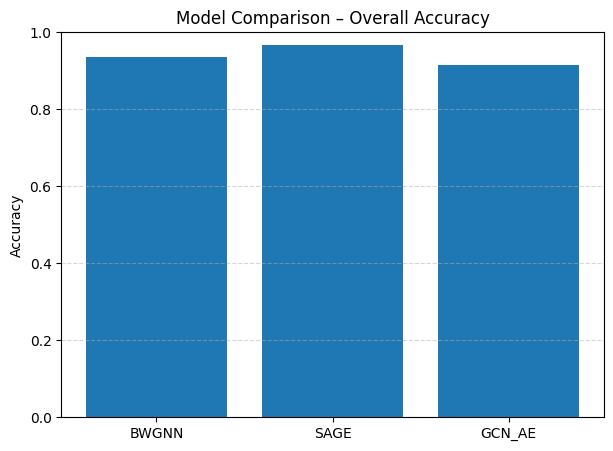

In [46]:
plt.figure(figsize=(7, 5))
plt.bar(df.index, df["accuracy"])
plt.ylabel("Accuracy")
plt.title("Model Comparison – Overall Accuracy")
plt.ylim(0, 1)
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()


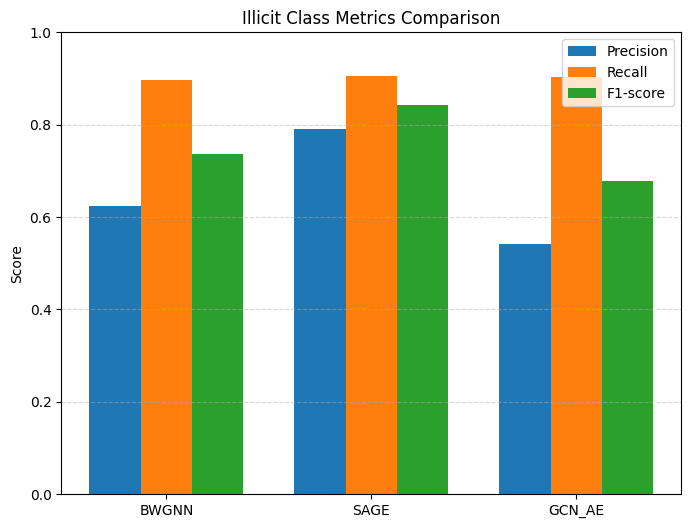

In [47]:
plt.figure(figsize=(8, 6))

metrics = ["precision_illicit", "recall_illicit", "f1_illicit"]
x = range(len(df.index))
width = 0.25

plt.bar([p - width for p in x], df[metrics[0]], width=width, label="Precision")
plt.bar(x, df[metrics[1]], width=width, label="Recall")
plt.bar([p + width for p in x], df[metrics[2]], width=width, label="F1-score")

plt.xticks(x, df.index)
plt.ylabel("Score")
plt.title("Illicit Class Metrics Comparison")
plt.ylim(0, 1)
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.5)
plt.show()

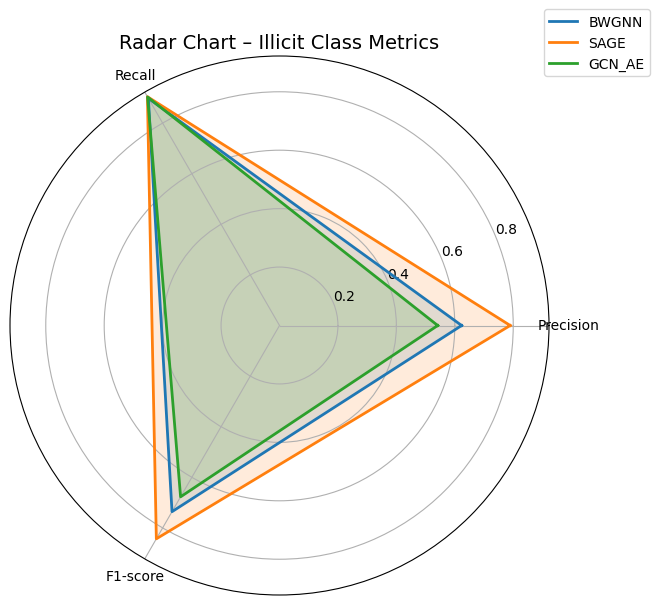

In [48]:
import numpy as np

labels = ["Precision", "Recall", "F1-score"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close circle

plt.figure(figsize=(7, 7))
ax = plt.subplot(111, polar=True)

for model in df.index:
    values = df.loc[model, ["precision_illicit", "recall_illicit", "f1_illicit"]].tolist()
    values += values[:1]  # close circle

    ax.plot(angles, values, linewidth=2, label=model)
    ax.fill(angles, values, alpha=0.15)

ax.set_thetagrids(np.degrees(angles[:-1]), labels)
plt.title("Radar Chart – Illicit Class Metrics", size=14)
plt.legend(loc="upper right", bbox_to_anchor=(1.2, 1.1))
plt.show()